In [1]:
from image_py_scripts import run_image_inpainting, convmc
import os
import torch 
from skimage import io, color, img_as_float
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
import numpy as np
import math
ROOT = 'C:/Users/Talha/OneDrive - Higher Education Commission/Documents/GitHub/convmc-net/'
DATA_PATH = os.path.join(ROOT, 'Image_Inpainting_Data')
SYNTHETIC_DATA_PATH = os.path.join(ROOT, 'Image_Inpainting_Dataset')


In [2]:
# Get parameters
def get_default_param(gpu = True):
    params_net = {}

    params_net['layers'] = 5 #1 #2 #3 #4 #5 #6 #7 #8 #9 #10
    params_net['kernel'] = [(3, 1)] * 3 + [(3, 1)] * 7
    params_net['initial_mu_inverse'] = 0.0

    params_net['initial_y1'] = 0.8

    params_net['coef_mu_inverse'] = 0.36

    params_net['CalInGPU'] = gpu # whether to calculate in GPU
    params_net['kernel'] = params_net['kernel'][0:params_net['layers']]
    params_net['rank'] = 10
    params_net['size1'] = 150
    params_net['size2'] = 300

    return params_net

model = convmc.UnfoldedNet2dC_convmc(get_default_param(gpu = False))

In [3]:
# Directory where the files are located
directory = SYNTHETIC_DATA_PATH

# Template for the file path
template = "Q {percentage}.0%/DB 5.0/Saved Models - Dict/ConvMC-Net/Session_1/ConvMC-Net_Sampling{percentage}.0%_GMM5.0_Layers_5_TrainInstances_20_Epochs_[20_out_of_20]_lr_0.12.pth"

# Define the directory for saving plots
save_directory = os.path.join(SYNTHETIC_DATA_PATH, "psnr_ssim_5db")

# List to store file paths
file_paths = []

# Iterate over percentages from 20 to 80
for percentage in range(20, 81, 10):
    # Construct the file path
    file_path = os.path.join(directory, template.format(percentage = percentage))
    # Append the file path to the list
    file_paths.append(file_path)

image_path = os.path.join(DATA_PATH, f"{1}.jpg")

In [4]:
M = run_image_inpainting.read_and_preprocess_image(image_path, 150, 300)

# Add GMM noise
M_Omega = run_image_inpainting.add_gmm_noise(M, 0.2, 5.0)
maxiter = 50

M, M_Omega


(array([[0.23344275, 0.26089373, 0.29226627, ..., 0.48203922, 0.46830235,
         0.46045922],
        [0.44391686, 0.42430902, 0.40077961, ..., 0.52008235, 0.52008235,
         0.51616078],
        [0.51616078, 0.51223922, 0.51616078, ..., 0.2909051 , 0.26317137,
         0.23208157],
        ...,
        [0.25109333, 0.25333333, 0.25333333, ..., 0.25166667, 0.2477451 ,
         0.2477451 ],
        [0.2477451 , 0.2477451 , 0.24831059, ..., 0.19030549, 0.19030549,
         0.19422706],
        [0.19058824, 0.19058824, 0.18666667, ..., 0.18613098, 0.19005255,
         0.19340863]]),
 tensor([[ 0.0488,  0.0000,  0.0000,  ...,  0.0000,  0.5331,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [-7.7195,  0.0000,  0.0000,  ...,  0.2257,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.1972,  0.0000,  0.1711],
         [ 0.0000,  0.1778,  0.0000,  ...,  0.2713,  0.2237,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ..

In [7]:
model_path = 'C:/Users/Talha/OneDrive - Higher Education Commission/Documents/GitHub/convmc-net/Image_Inpainting_Data/BSDS300/images/Q 20.0%/DB 5.0/Saved Models - Dict/ConvMC-Net/Session_1/_Layers_5_TrainInstances_20_Epochs_[1_out_of_1]_lr_0.12.pth'

In [8]:
# model_path = file_paths[0].replace('\\', '/')
model.load_state_dict(torch.load(model_path, map_location = 'cpu'))
model.eval()
with torch.no_grad():
    M_omega_reconstructed = (model([M_Omega]))[0][1]
    M_omega_reconstructed = M_omega_reconstructed.numpy()
    M_omega_reconstructed = M_omega_reconstructed.astype(np.float64)

M_omega_reconstructed

array([[1.28995562, 1.16627109, 1.05316937, ..., 0.66688073, 1.00448418,
        1.20678604],
       [0.84769791, 0.76224387, 0.70050806, ..., 0.43909717, 0.65943325,
        0.79612249],
       [0.63212061, 0.56784844, 0.54682362, ..., 0.3264319 , 0.48022199,
        0.57869768],
       ...,
       [0.77536666, 0.71024162, 0.70269692, ..., 0.40568632, 0.60940713,
        0.71733671],
       [0.95976812, 0.87258971, 0.84529436, ..., 0.49868235, 0.74161875,
        0.88221568],
       [0.64423579, 0.59422421, 0.47367048, ..., 0.3386595 , 0.5219565 ,
        0.63155097]])

In [14]:
M.dtype, M_omega_reconstructed.dtype

(dtype('float64'), dtype('float64'))

In [15]:
ssim(M, M_omega_reconstructed, data_range = M_omega_reconstructed.max() - M_omega_reconstructed.min())

0.40063827292429155

In [3]:
# Main function
def main():
    # Directory where the files are located
    directory = SYNTHETIC_DATA_PATH

    # Template for the file path
    template = "Q {percentage}.0%/DB 5.0/Saved Models - Dict/ConvMC-Net/Session_1/ConvMC-Net_Sampling{percentage}.0%_GMM5.0_Layers_5_TrainInstances_20_Epochs_[20_out_of_20]_lr_0.12.pth"

    # Define the directory for saving plots
    save_directory = os.path.join(SYNTHETIC_DATA_PATH, "psnr_ssim_5db")

    # List to store file paths
    file_paths = []

    # Iterate over percentages from 20 to 80
    for percentage in range(20, 81, 10):
        # Construct the file path
        file_path = os.path.join(directory, template.format(percentage = percentage))
        # Append the file path to the list
        file_paths.append(file_path)

    # Run the image inpainting pipeline
    run_image_inpainting.run_image_inpainting_pipeline(file_paths, save_directory, model)

c:\Users\Talha\OneDrive - Higher Education Commission\Documents\GitHub\convmc-net\image_py_scripts\run_image_inpainting.py:46: UserWarning: Inputs have mismatched dtype.  Setting data_range based on image_true.
  PSNR = psnr(M, M_omega_reconstructed)


Model: ConvMC-Net, PSNR of Image 1 = 4.62455583060669, SSIM of Image 1 = 0.013736401036129815
Model: ConvMC-Net, PSNR of Image 2 = 7.139390588516426, SSIM of Image 2 = 0.019113152021484784
Model: ConvMC-Net, PSNR of Image 3 = 1.9121423057270555, SSIM of Image 3 = 0.006913774558610714
Model: ConvMC-Net, PSNR of Image 4 = 3.4854673338236832, SSIM of Image 4 = 0.018903978060082195
Model: ConvMC-Net, PSNR of Image 5 = 5.962310360433506, SSIM of Image 5 = 0.01503611534020566
Model: ConvMC-Net, PSNR of Image 6 = 6.489476522248526, SSIM of Image 6 = 0.016341835008703218
Model: ConvMC-Net, PSNR of Image 7 = 2.387387194468766, SSIM of Image 7 = 0.008050241647316509
Model: ConvMC-Net, PSNR of Image 8 = -2.21669499694731, SSIM of Image 8 = 0.01033414454785502
Model: ConvMC-Net, PSNR of Image 1 = 2.4473442719424163, SSIM of Image 1 = 0.01514031301555047
Model: ConvMC-Net, PSNR of Image 2 = 5.203160650963023, SSIM of Image 2 = 0.022140117313162323
Model: ConvMC-Net, PSNR of Image 3 = 0.457362699863

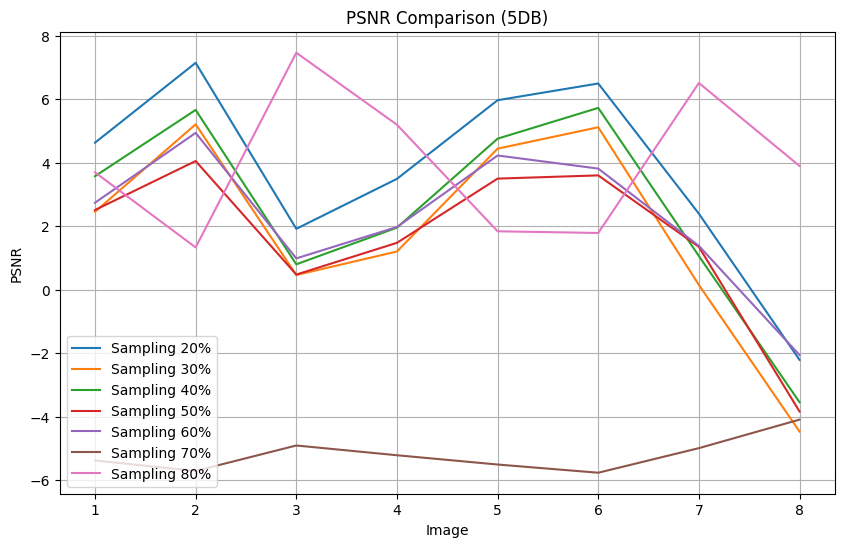

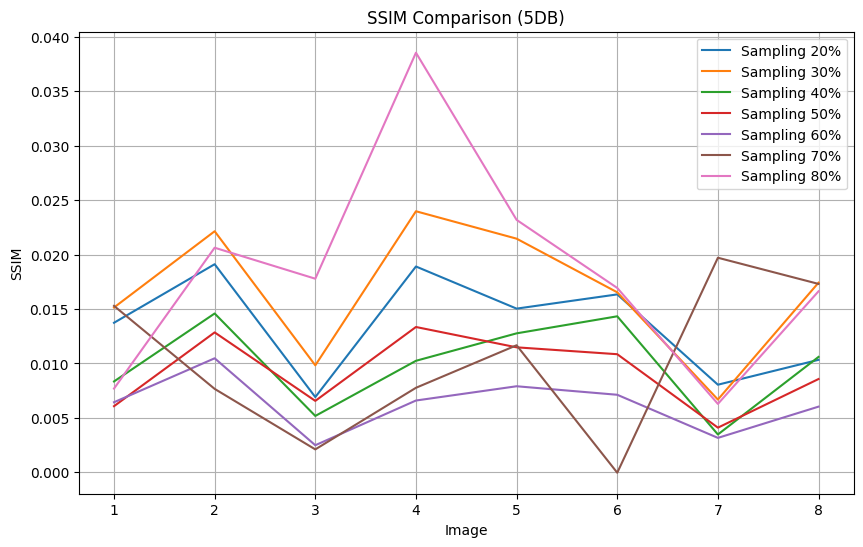

In [4]:
# Call the main function
if __name__ == "__main__":
    main()